## ML Classification: Loan predictions


In [1]:
# Loading libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
import joblib
import pickle

from scipy.stats import skew
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Data ingestion
df = pd.read_csv("loan_data.csv")

In [3]:
# Checking first 5 rows of dataset
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0


# EDA
- Conducting a statistical analysis of the dataset and make some visualizations so as to understand the data

In [4]:
# Schema of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit.policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int.rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log.annual.inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days.with.cr.line  9578 non-null   float64
 8   revol.bal          9578 non-null   int64  
 9   revol.util         9578 non-null   float64
 10  inq.last.6mths     9578 non-null   int64  
 11  delinq.2yrs        9578 non-null   int64  
 12  pub.rec            9578 non-null   int64  
 13  not.fully.paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


## Notes
- The dataset has 1 object, 7 int 64 and 6 float64 data types.
- dataset has a total of 9578 entries with no null values

In [5]:
# Number of unique values in each column
df.nunique()

credit.policy           2
purpose                 7
int.rate              249
installment          4788
log.annual.inc       1987
dti                  2529
fico                   44
days.with.cr.line    2687
revol.bal            7869
revol.util           1035
inq.last.6mths         28
delinq.2yrs            11
pub.rec                 6
not.fully.paid          2
dtype: int64

- There are discrete and continuous variables

### Statistical summary of numerical variables in the dataset

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
credit.policy,9578.0,0.804970,0.396245,0.000000,1.000000,1.000000,1.000000,1.000000e+00
int.rate,9578.0,0.122640,0.026847,0.060000,0.103900,0.122100,0.140700,2.164000e-01
installment,9578.0,319.089413,207.071301,15.670000,163.770000,268.950000,432.762500,9.401400e+02
log.annual.inc,9578.0,10.932117,0.614813,7.547502,10.558414,10.928884,11.291293,1.452835e+01
dti,9578.0,12.606679,6.883970,0.000000,7.212500,12.665000,17.950000,2.996000e+01
fico,9578.0,710.846314,37.970537,612.000000,682.000000,707.000000,737.000000,8.270000e+02
days.with.cr.line,9578.0,4560.767197,2496.930377,178.958333,2820.000000,4139.958333,5730.000000,1.763996e+04
revol.bal,9578.0,16913.963876,33756.189557,0.000000,3187.000000,8596.000000,18249.500000,1.207359e+06
revol.util,9578.0,46.799236,29.014417,0.000000,22.600000,46.300000,70.900000,1.190000e+02
inq.last.6mths,9578.0,1.577469,2.200245,0.000000,0.000000,1.000000,2.000000,3.300000e+01


## Notes
- The numerical variables have varying scales hence scaling can be performed
- Differences between mean and median indicate some skewness on some features e.g. revol.bal, instalment etc
- Log transformation can also be appplied to continuous variables
- High std indicates variability in a feature, as indicated by the revol.bal etc
- No null values in data
- Outliers can be observed since there are some large difrences between mean and median on features e.g. revol.bal

### Graphical visualization of the distribution of features

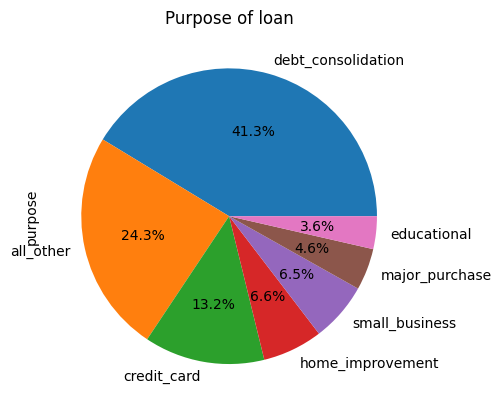

In [7]:
# Categorical features
df['purpose'].value_counts().plot(kind="pie",
                              autopct ="%1.1f%%", title ="Purpose of loan")
plt.show()

### Observation
- Debt_consolidation is the most frequent purpose for borrowing loan
- Educational is the least popular purpose

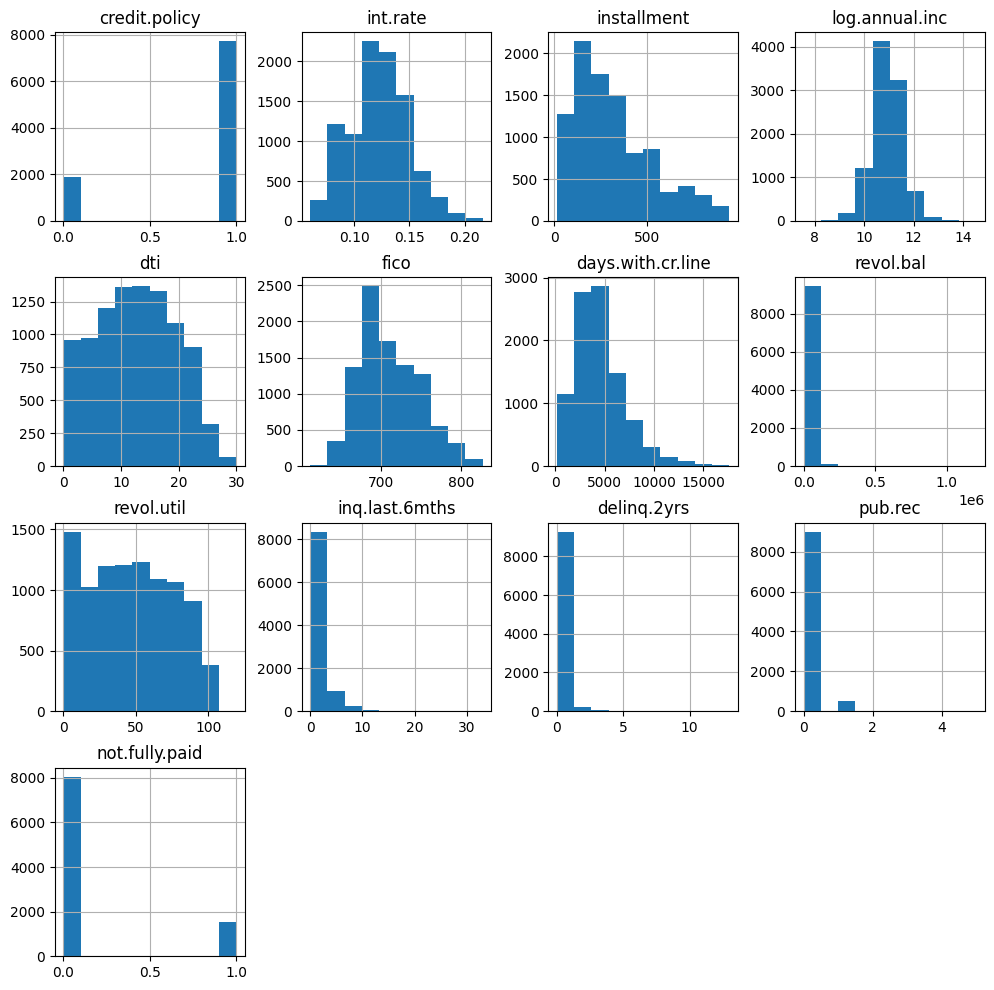

In [8]:
# Distribution of numerical columns
df.hist(figsize=(12,12))
plt.show()

### Notes
-The histograms showed the distribution of features
- Fico, int.rate and log.annual.inc are normally distributed
- Logarithmic transformation can be done on the features which are skewed e.g
- Features have different ranges of distribution hence feature scaling is a necesity  

### Visualizing correlations on heatmap

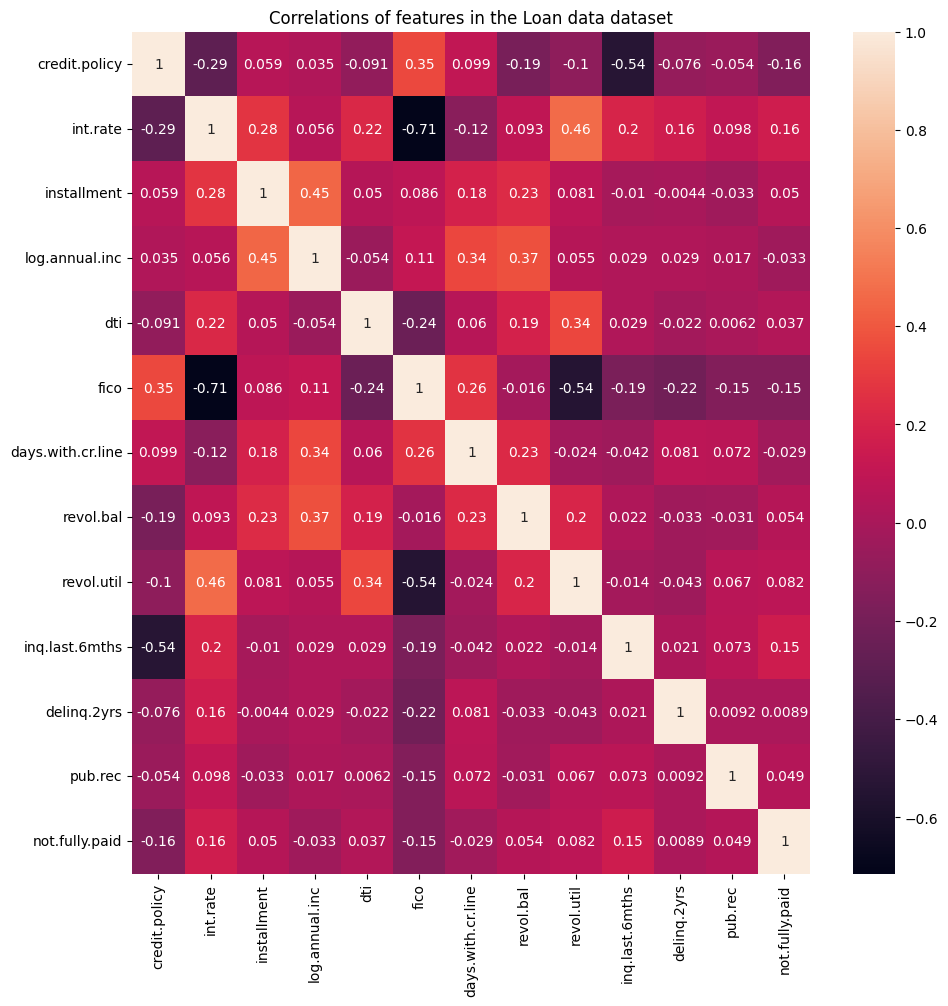

In [9]:
figure = plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot = True)
plt.tight_layout()
plt.title("Correlations of features in the Loan data dataset")
plt.show()

### Inference
- Fico and interset rate recorded the highest correlation of 71%
- There are no extreme cases of correlation hence using all the features for modelling

### Checking for outliers

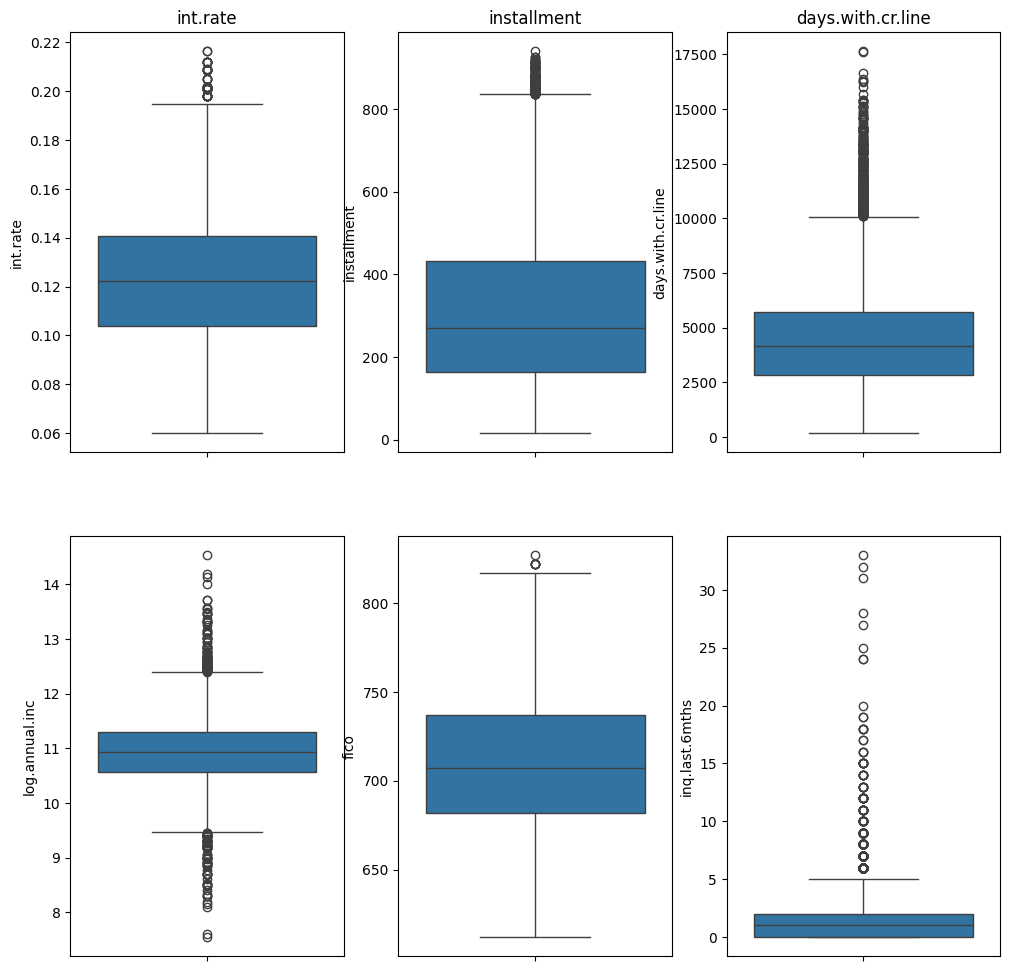

In [10]:
#Checking for outliers
figure = plt.figure(figsize=(12,12))
plt.subplot(2,3,1)
sns.boxplot(df["int.rate"])
plt.title("int.rate")

plt.subplot(2,3,2)
sns.boxplot(df["installment"])
plt.title("installment")

plt.subplot(2,3,3)
sns.boxplot(df["days.with.cr.line"])
plt.title("days.with.cr.line")

plt.subplot(2,3,4)
sns.boxplot(df["log.annual.inc"])

plt.subplot(2,3,5)
sns.boxplot(df["fico"])

plt.subplot(2,3,6)
sns.boxplot(df["inq.last.6mths"])

plt.show()

## Notes
- There are outliers in the nuemrical features which may need to be handled  

# Analyzing the target column

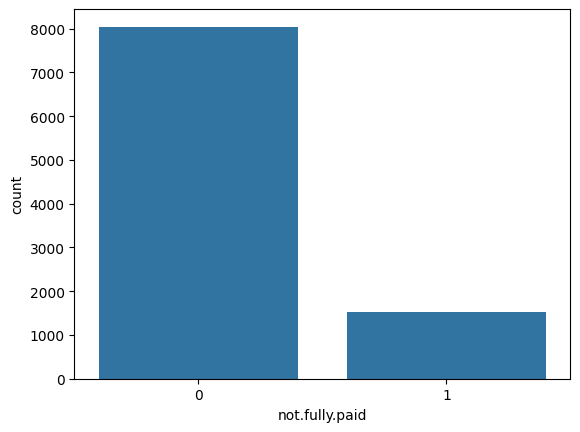

In [11]:
# Distribution of not.fully .paid column
sns.countplot(x='not.fully.paid', data=df)
plt.show()

### Notes
- The target variable ["not.fully.paid"] is biased
- Oversampling to be done using SMOTE algorithm inorder to balance the dataset

# Data wrangling
- Cleaning data and transforming the features in preparation for data modeling

### Checking for missing numbers

In [12]:
df.isna().sum().any()

False

There are no misssing values in the dataset

### Checking for duplicates

In [13]:
df.duplicated().any()

False

The dataset has no duplicates

### Checking for variablitity in features

In [14]:
df.nunique()==1

credit.policy        False
purpose              False
int.rate             False
installment          False
log.annual.inc       False
dti                  False
fico                 False
days.with.cr.line    False
revol.bal            False
revol.util           False
inq.last.6mths       False
delinq.2yrs          False
pub.rec              False
not.fully.paid       False
dtype: bool

### Notes:
- There is some variablity in all columns hence all columns are informative

#Handling outliers
- Outliers should not be automatically removed because they may be useful and bring important information to prediction models.
- However since this project is for learning purposes, I'll expore how to remove the outliers.

In [15]:
#Removing outliers
df = df[(df['int.rate']<0.19)& (df["installment"]<835)&
                       (df["days.with.cr.line"]<9450)&(df["fico"]<815)&
                       (df["inq.last.6mths"]<5)&(df["log.annual.inc"]<12.3)&
                       (df["log.annual.inc"]>9.4)&(df["dti"]<34)]

In [16]:
df.shape

(7948, 14)

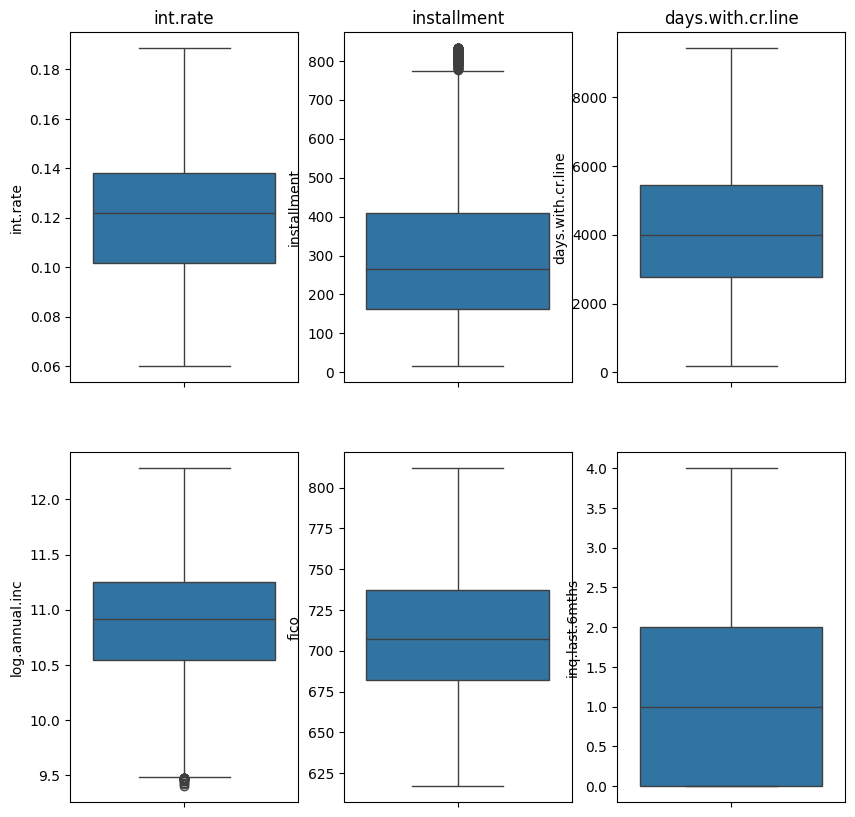

In [17]:
#Rechecking to see if all outliers are handled
figure = plt.figure(figsize=(10,10))
plt.subplot(2,3,1)
sns.boxplot(df["int.rate"])
plt.title("int.rate")

plt.subplot(2,3,2)
sns.boxplot(df["installment"])
plt.title("installment")

plt.subplot(2,3,3)
sns.boxplot(df["days.with.cr.line"])
plt.title("days.with.cr.line")

plt.subplot(2,3,4)
sns.boxplot(df["log.annual.inc"])

plt.subplot(2,3,5)
sns.boxplot(df["fico"])

plt.subplot(2,3,6)
sns.boxplot(df["inq.last.6mths"])

plt.show()

### Notes
- There are some outliers remaining even after removing the majority of outliers

## Feature engineering
- Log transformation on skewed numerical columns, Encoding and scaling data

In [18]:
#Separating features and target
X = df.drop(columns=['not.fully.paid'],axis=1)
y = df['not.fully.paid']

In [19]:
categorical_columns = [i for i in X.columns if X[i].dtype=='O']
categorical_columns

['purpose']

In [20]:
numerical_columns = [i for i in X.columns if i not in categorical_columns]
numerical_columns

['credit.policy',
 'int.rate',
 'installment',
 'log.annual.inc',
 'dti',
 'fico',
 'days.with.cr.line',
 'revol.bal',
 'revol.util',
 'inq.last.6mths',
 'delinq.2yrs',
 'pub.rec']

In [21]:
skewness = X[numerical_columns].apply(lambda x: skew(x))
print(skewness)


credit.policy       -2.202446
int.rate             0.020404
installment          0.811865
log.annual.inc      -0.058821
dti                  0.009017
fico                 0.433146
days.with.cr.line    0.459441
revol.bal            5.115431
revol.util           0.051541
inq.last.6mths       0.893526
delinq.2yrs          4.499062
pub.rec              5.080534
dtype: float64


In [22]:
#Selecting columns with skewness of greater than 1 for log transformation
threshold = 1
skewed_columns = skewness[skewness > threshold].index.tolist()
skewed_columns

['revol.bal', 'delinq.2yrs', 'pub.rec']

In [23]:
# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('log_transform', FunctionTransformer(np.log1p,validate = True),skewed_columns),
        ('num', MinMaxScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ])

In [24]:
# Fitting the preprocessor
X_preprocessed = preprocessor.fit_transform(X)

In [25]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

In [26]:
# balancing the dataset
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [27]:
# Checking if dataset is balanced
print('Y_train\n', y_train.value_counts(), '\n')
print('Y_train_resampled\n', y_train_resampled.value_counts())

Y_train
 0    5438
1     920
Name: not.fully.paid, dtype: int64 

Y_train_resampled
 0    5438
1    5438
Name: not.fully.paid, dtype: int64


### Notes
- The dataset was successfully balanced
- Sampling techniques like smote are only applied to the training data to avoid data leakages
- That way the model evaluation will also be realistic on the unseen test data

## Traditional Machine Classifiers

In [28]:
models = {
    "Logistic Regression": LogisticRegression(),
    "SVC": SVC(),
    "Random Forest Classifier": RandomForestClassifier(),
    "XGBClassifier": XGBClassifier(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "KNeighbors Classifier": KNeighborsClassifier(),
    "Ada Boost Classifier": AdaBoostClassifier()
}

model_list = []
accuracy_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train_resampled, y_train_resampled)

    # Predictions
    y_train_pred = model.predict(X_train_resampled)
    y_test_pred = model.predict(X_test)

    # Evaluate Train and Test dataset
    train_accuracy  = accuracy_score(y_train_resampled, y_train_pred)

    test_accuracy  = accuracy_score(y_test, y_test_pred)


    print(list(models.keys())[i],'\n')
    model_list.append(list(models.keys())[i])

    print('Training accuracy is', train_accuracy,'\n')
    print('Test accuracy is', test_accuracy, '\n')

    accuracy_list.append(test_accuracy)
    print('*'*40)
    print()

Logistic Regression 

Training accuracy is 0.6204486943729313 

Test accuracy is 0.6050314465408805 

****************************************

SVC 

Training accuracy is 0.6237587348289813 

Test accuracy is 0.5773584905660377 

****************************************

Random Forest Classifier 

Training accuracy is 1.0 

Test accuracy is 0.8333333333333334 

****************************************

XGBClassifier 

Training accuracy is 0.9794961382861346 

Test accuracy is 0.8471698113207548 

****************************************

Decision Tree Classifier 

Training accuracy is 1.0 

Test accuracy is 0.7264150943396226 

****************************************

KNeighbors Classifier 

Training accuracy is 0.8618977565281354 

Test accuracy is 0.6125786163522012 

****************************************

Ada Boost Classifier 

Training accuracy is 0.7442074292019125 

Test accuracy is 0.7238993710691823 

****************************************



In [29]:
pd.DataFrame(list(zip(model_list,accuracy_list)), columns=['Model Name', 'Accuracy score']).sort_values(by=["Accuracy score"],ascending=False)

,Model Name,Accuracy score
3,XGBClassifier,0.847170
2,Random Forest Classifier,0.833333
4,Decision Tree Classifier,0.726415
6,Ada Boost Classifier,0.723899
5,KNeighbors Classifier,0.612579
0,Logistic Regression,0.605031
1,SVC,0.577358


## Notes
- XGBClassifier performed best
- A good fit is observed in models e.g. Logistic regression and Ada boost classifier
- A large gap between the training and testing accuracies in models e.g Random forest classifier, Decision tree classifier and KNN classifier does suggest a possibility of overfitting

# Hyper parameter tuning on the best performing model


### Notes
- Cross-validation is used in hyperparameter tuning to estimate the performance of each hyperparameter configuration.
- It helps prevent overfitting hyperparameters to a specific train-test split, ensuring the chosen hyperparameters generalize well to new data.

In [30]:
xgb_model = XGBClassifier()

In [31]:
cv_scores = cross_val_score(xgb_model, X_train_resampled, y_train_resampled, cv=5)

In [32]:
print("Cross-Validation Scores:", cv_scores,'\n')
print(f"Mean Accuracy: {cv_scores.mean():.2f}")

Cross-Validation Scores: [0.61856618 0.94574713 0.94344828 0.93517241 0.94482759] 

Mean Accuracy: 0.88


In [33]:
param_grid = {
    'classifier__n_estimators': [100, 200, 250, 300,500],
    'classifier__max_depth': [1, 3, 5, 7],
    'classifier__learning_rate': [0.01, 0.001, 0.1, 0.2]
}

In [34]:
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=10,
    scoring='accuracy',
    cv=5
    )

In [35]:
random_search.fit(X_train_resampled, y_train_resampled)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   param_distributions={'classifier__learning_rate': [0.01,
                                                                      0.001,
                                                                      0.1,
                                                                      0.2],
                                        'classifier__max_depth': [1, 3, 5, 7],
                                        'classifier__n_estimators': [100, 200,
                                                                     250, 300,
                                                                     500]},
                   scoring='accuracy')

In [36]:
print("Best Parameters:", random_search.best_params_,'\n')
print("Best Score:", random_search.best_score_)

Best Parameters: {'classifier__n_estimators': 100, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.001} 

Best Score: 0.8775523157538878


## Checking the accuracy of the best parameters

In [37]:
best_xgb_model =XGBClassifier(n_estimators=300, max_depth =1, learning_rate= 0.01)

In [38]:
best_xgb_model.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [39]:
best_xgb_predictions = best_xgb_model.predict(X_test)

In [40]:
print('XG boost with hyper parameter tuning accuracy score is : ', accuracy_score(y_test,best_xgb_predictions))

XG boost with hyper parameter tuning accuracy score is :  0.5578616352201258


## Notes
- A decrease in accuracy after hyperparameter tuning can be due to many factor which may need further investigation.
- Randomness, model complexity, tuning could have introduced regularization or other measures to reduce overfitting or even underfitting: it's possible that the hyperparameters were not tuned effectively, leading to underfitting.

# Model persistence

In [41]:
joblib.dump(best_xgb_model, 'loan_classifier.joblib')

['loan_classifier.joblib']

In [42]:
#Loading model later
model = joblib.load('loan_classifier.joblib')

In [43]:
# Making predictions using the loaded model
predictions = model.predict(X_test)


### Pickling

In [44]:
with open('best_xgb_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [45]:
with open('best_xgb_model.pkl', 'rb') as file:
    loan_model = pickle.load(file)


In [46]:
# Make predictions using the loaded model
predictions = loan_model.predict(X_test)